# Outer approximation: verify whether a given behavior $\vec{p}$ is not in $\mathcal{Q}_d$


A quantum behavior satisfies $\vec{p} = (p_1, p_2, ..., p_n)\in\mathcal{Q}_d$ if and only if the following problem is feasible

(Eq. 1)
$$\begin{align}
\mathrm{find}\quad & \Phi_{AB}\in\mathrm{SEP}\\
\mathrm{s.t.}\quad & V_{AB}\Phi_{AB} = \Phi_{AB},~\mathrm{Tr}(\Phi_{AB}) = (n+1)^2,\\
& \mathrm{Tr}_A[(|i\rangle\langle j|\otimes\mathbb{I}_d\otimes\mathbb{I}_B)\Phi_{AB} ] = 0 ~~ \text{for} ~~ \{i,j\}\in E,\\
& \mathrm{Tr}_A[(|i\rangle\langle i|\otimes\mathbb{I}_d\otimes\mathbb{I}_B)\Phi_{AB} ] = \frac{1}{n+1}\mathrm{Tr}_A[\Phi_{AB}],\\
& \mathrm{Tr}_A[(|0\rangle\langle i|\otimes\mathbb{I}_d\otimes\mathbb{I}_B)\Phi_{AB} ] = \frac{\sqrt{p_i}}{n+1}\mathrm{Tr}_A[\Phi_{AB}].\\
\end{align}
$$

Consider the PPT relaxation, the problem is feasible only if the solution of the following optimization is nonnegative.

(Eq. 2)
$$\begin{align}
\max_{\Phi_I,~\Phi_V,~\eta}\quad & \eta\\
\mathrm{s.t.}~~~\quad & \Phi_I + \Phi_V \ge \eta \mathbb{I}, ~ \Phi_I - \Phi_V \ge \eta \mathbb{I},\\
& \Phi_I^{T_{A_1}} \ge \eta \mathbb{I}, ~ \Phi_I^{T_{A_1}} + d\Phi_V^{T_{A_1}} \ge \eta \mathbb{I},\\
& \Phi_V = V_{A_1B_1} \Phi_I, ~ \mathrm{Tr}(d \Phi_I + \Phi_V) = \frac{1}{d}(n + 1)^2,\\
& \mathrm{Tr}_{A_1}[(|i\rangle\langle j|\otimes\mathbb{I}_{n+1}) (d \Phi_I + \Phi_V)] = 0 ~~ \text{for} ~~ \{i,j\}\in E,\\
& \mathrm{Tr}_{A_1}[(|i\rangle\langle i|\otimes\mathbb{I}_{n+1}) (d \Phi_I + \Phi_V)] = \frac{1}{n+1}\mathrm{Tr}_{A_1}[d \Phi_I + \Phi_V],\\
& \mathrm{Tr}_{A_1}[(|0\rangle\langle i|\otimes\mathbb{I}_{n+1}) (d \Phi_I + \Phi_V)] = \frac{\sqrt{p_i}}{n+1}\mathrm{Tr}_{A_1}[d \Phi_I + \Phi_V].\\
\end{align}
$$

In principle, $\Phi_I$ and $\Phi_V$ should be Hermitian matrices. However, as all the parameters involved in (Eq. 2) are real, $\Phi_I$ and $\Phi_V$ can be restricted to be real symmetric matrices.

In [1]:
import numpy as np
import cvxpy as cvx
import networkx as nx
import scipy.linalg as lin

/tmp/ipykernel_26875/811224743.py:9: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  G = nx.adjacency_matrix(graph, dtype=float).todense()


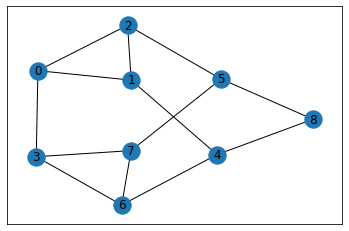

In [2]:
# Define the graph (in graph6 format)
graph = nx.from_graph6_bytes(b'H{O_okK')

# draw the graph
nx.draw_networkx(graph)


# G is the adjacency matrix
G = nx.adjacency_matrix(graph, dtype=float).todense()
#print("The adjacency matrix:\n", G)


# n is the number of vertices
n = G.shape[0]
#print("Number of vertices:", n)

In [3]:
# V_{A_1B_1}

V = np.zeros((n + 1, n + 1, n + 1, n + 1))
for i in range(n + 1):
    for j in range(n + 1):
        V[i,j,j,i] = 1
        
V = V.reshape(((n + 1)**2, (n + 1)**2))
        
# edge indexing
GG = np.zeros([n + 1, n + 1])
GG[1:, 1:] = G

#I_{(n+1)**2}
Id = np.identity((n+1)**2)

In [4]:
# Construct the SDP

d = cvx.Parameter(nonneg=True) # d
proot = cvx.Parameter(n, nonneg=True) # sqrt(p)

lam = cvx.Variable()
PhiP = cvx.Variable(((n + 1) ** 2, (n + 1) ** 2), symmetric=True) # PhiI + PhiV
PhiM = cvx.Variable(((n + 1) ** 2, (n + 1) ** 2), symmetric=True) # PhiI - PhiV
PhiT = cvx.Variable(((n + 1) ** 2, (n + 1) ** 2), symmetric=True) # PhiI^T (partial transpose)
PhiTD = cvx.Variable(((n + 1) ** 2, (n + 1) ** 2), symmetric=True) # PhiI^T + d*PhiV^T


PhiI = (PhiP + PhiM)/2
PhiV = (PhiP - PhiM)/2
PhiDV = d * PhiI + PhiV

# obj = cvx.Maximize(cvx.lambda_min(PhiP)
#                    +cvx.lambda_min(PhiM)
#                    +cvx.lambda_min(PhiT)
#                    +cvx.lambda_min(PhiTK)
#                   )


# Express PhiDV as (n+1)*(n+1) block matrices
Slice = [[PhiDV[i*(n+1):(i+1)*(n+1), j*(n+1):(j+1)*(n+1)]
          for i in range(n + 1)]
         for j in range(n + 1)]


obj = cvx.Maximize(lam)

cons = []

cons += [PhiP >> lam * Id, PhiM >> lam * Id,
         PhiT >> lam * Id, PhiTD >> lam * Id]

cons += [V @ PhiP == PhiP, V @ PhiM == - PhiM]
cons += [cvx.partial_transpose(PhiT, dims=[n + 1, n + 1], axis=0) == PhiI,
         cvx.partial_transpose(PhiTD, dims=[n + 1, n + 1], axis=0) == PhiI + d * PhiV]


cons += [cvx.multiply(np.kron(GG, np.ones([n + 1, n + 1])), PhiDV) == 0]
cons += [Slice[i][i] == Slice[0][0] for i in range(1, n + 1)]
cons += [Slice[0][i] == proot[i-1] * Slice[0][0] for i in range(1, n + 1)]
cons += [cvx.trace(Slice[0][0]) == (n + 1) / d]


prob = cvx.Problem(obj, cons)

In [5]:
p1 = np.array([1/3,1/3,1/3,1/3,1/3,1/3,1/3,1/3,1/3])
p2 = np.array([1/2,1/4,1/4,1/2,0,0,1/4,1/4,1])
p3 = np.array([5/12,7/24,7/24,5/12,1/6,1/6,7/24,7/24,2/3])

print("p3 = (p1 + p2) / 2 ?", np.allclose(p3, (p1 + p2) / 2))

p3 = (p1 + p2) / 2 ? True


In [6]:
d.value = 3
proot.value = np.sqrt(p1)
prob.solve(solver="MOSEK", ignore_dpp=True, verbose=False)
print(prob.value)
proot.value = np.sqrt(p2)
prob.solve(solver="MOSEK", ignore_dpp=True, verbose=False)
print(prob.value)
proot.value = np.sqrt(p3)
prob.solve(solver="MOSEK", ignore_dpp=True, verbose=False)
print(prob.value)

-8.245025400024064e-14
-8.132511378056856e-10
-0.0005654199794574065


In [7]:
p4 = np.array([1/3,1/3,1/3,0,2/3,1/3,0,0,1/3])

In [8]:
d.value = 4
proot.value = np.sqrt(p4)
prob.solve(solver="MOSEK", ignore_dpp=True, verbose=False)
print(prob.value)

-0.0006065330258475833
